Fetching basic website metrics...
Data Summary:
--------------------------------------------------
Total Sessions: 5388
Total Users: 4598
Total Pageviews: 19488
Average Bounce Rate: 0.07%
Average Session Duration: 202.86 seconds
--------------------------------------------------

Daily Metrics:
        Date  Sessions  Users  Pageviews  Bounce Rate  Avg Session Duration
0 2025-03-13       312    273        989     0.035256            107.750805
1 2025-03-11       309    264       1017     0.051780            138.483335
2 2025-03-10       236    204        944     0.055085            178.537139
3 2025-03-12       215    192        568     0.046512            114.223337
4 2025-03-14       213    180        803     0.042254            171.244740


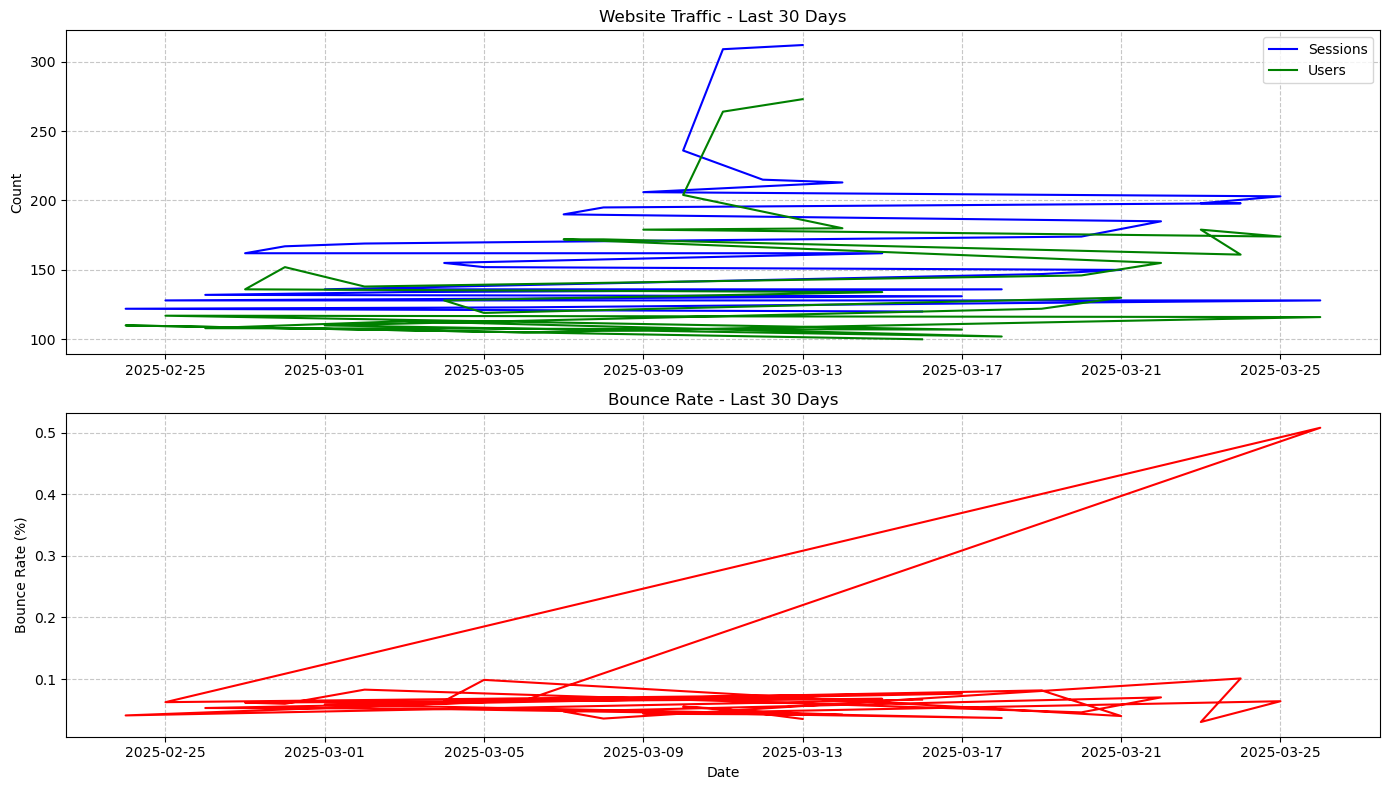


Fetching traffic sources...

Top Traffic Sources:
                    Source     Medium  Sessions  Bounce Rate  \
0                   google        cpc      3583     0.046888   
1                 (direct)     (none)       948     0.114979   
2                   google    organic       491     0.061100   
3                (not set)  (not set)        52     1.000000   
4           127.0.0.1:5500   referral        52     0.269231   
5  tagassistant.google.com   referral        36     0.083333   
6                     bing    organic        31     0.129032   
7                  l.wl.co   referral        25     0.160000   
8          l.instagram.com   referral        20     0.000000   
9          next.telecrm.in   referral        20     0.400000   

   Avg Session Duration  
0            141.630625  
1            332.380528  
2            196.717195  
3            191.130153  
4            126.184750  
5            331.527133  
6            357.644456  
7            200.215602  
8         

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from google.oauth2 import service_account
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set up authentication with a service account
def initialize_analytics():
    # Get the credentials path from environment variable
    KEY_FILE_LOCATION = os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/rakesh/Desktop/API/urbanmop-452423-9b8929084c77.json'
    
    if not KEY_FILE_LOCATION:
        raise ValueError("GOOGLE_APPLICATION_CREDENTIALS environment variable not set")
    
    SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
    
    credentials = service_account.Credentials.from_service_account_file(
        KEY_FILE_LOCATION, scopes=SCOPES)
    
    # Create a GA4 client using the discovery API (works with existing libraries)
    analytics = build('analyticsdata', 'v1beta', credentials=credentials)
    
    return analytics

# Get basic metrics by date
def get_basic_report(analytics, property_id):
    return analytics.properties().runReport(
        property=f"properties/{property_id}",
        body={
            'dateRanges': [{'startDate': '30daysAgo', 'endDate': 'today'}],
            'dimensions': [{'name': 'date'}],
            'metrics': [
                {'name': 'sessions'},
                {'name': 'totalUsers'},
                {'name': 'screenPageViews'},
                {'name': 'bounceRate'},
                {'name': 'averageSessionDuration'}
            ]
        }
    ).execute()

# Parse GA4 response to DataFrame
def parse_ga4_response(response):
    rows_data = []
    
    # Extract dimension and metric headers
    dimension_headers = [header['name'] for header in response.get('dimensionHeaders', [])]
    metric_headers = [header['name'] for header in response.get('metricHeaders', [])]
    all_headers = dimension_headers + metric_headers
    
    # Extract data from each row
    for row in response.get('rows', []):
        dimension_values = [dim['value'] for dim in row.get('dimensionValues', [])]
        metric_values = [met['value'] for met in row.get('metricValues', [])]
        
        row_data = dimension_values + metric_values
        rows_data.append(row_data)
    
    # Create DataFrame
    df = pd.DataFrame(rows_data, columns=all_headers)
    
    # Format date and convert metrics to numeric
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    
    # Convert numeric columns
    numeric_columns = metric_headers
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col])
    
    # Rename columns for better readability
    df = df.rename(columns={
        'date': 'Date',
        'sessions': 'Sessions',
        'totalUsers': 'Users',
        'screenPageViews': 'Pageviews',
        'bounceRate': 'Bounce Rate',
        'averageSessionDuration': 'Avg Session Duration'
    })
    
    return df

# Get traffic sources data
def get_traffic_sources(analytics, property_id):
    return analytics.properties().runReport(
        property=f"properties/{property_id}",
        body={
            'dateRanges': [{'startDate': '30daysAgo', 'endDate': 'today'}],
            'dimensions': [
                {'name': 'sessionSource'},
                {'name': 'sessionMedium'}
            ],
            'metrics': [
                {'name': 'sessions'},
                {'name': 'bounceRate'},
                {'name': 'averageSessionDuration'}
            ],
            'orderBys': [
                {
                    'metric': {'metricName': 'sessions'},
                    'desc': True
                }
            ],
            'limit': 10
        }
    ).execute()

# Get top pages data
def get_page_data(analytics, property_id):
    return analytics.properties().runReport(
        property=f"properties/{property_id}",
        body={
            'dateRanges': [{'startDate': '30daysAgo', 'endDate': 'today'}],
            'dimensions': [{'name': 'pagePath'}],
            'metrics': [
                {'name': 'screenPageViews'},
                {'name': 'screenPageViewsPerSession'},
                {'name': 'averageSessionDuration'},
                {'name': 'bounceRate'}
            ],
            'orderBys': [
                {
                    'metric': {'metricName': 'screenPageViews'},
                    'desc': True
                }
            ],
            'limit': 10
        }
    ).execute()

# Main execution
def main():
    # Initialize the Analytics API client
    analytics = initialize_analytics()
    
    # Get property ID from environment variables or use a default
    property_id = os.getenv('GA4_PROPERTY_ID', '276468663')
    
    try:
        print("Fetching basic website metrics...")
        response = get_basic_report(analytics, property_id)
        df = parse_ga4_response(response)
        
        # Display basic stats
        print("Data Summary:")
        print("-" * 50)
        print(f"Total Sessions: {df['Sessions'].sum()}")
        print(f"Total Users: {df['Users'].sum()}")
        print(f"Total Pageviews: {df['Pageviews'].sum()}")
        print(f"Average Bounce Rate: {df['Bounce Rate'].mean():.2f}%")
        print(f"Average Session Duration: {df['Avg Session Duration'].mean():.2f} seconds")
        print("-" * 50)
        
        # Display the first few rows
        print("\nDaily Metrics:")
        print(df.head())
        
        # Create visualization
        plt.figure(figsize=(14, 8))
        
        # Plot sessions and users
        ax1 = plt.subplot(2, 1, 1)
        ax1.plot(df['Date'], df['Sessions'], 'b-', label='Sessions')
        ax1.plot(df['Date'], df['Users'], 'g-', label='Users')
        ax1.set_title('Website Traffic - Last 30 Days')
        ax1.set_ylabel('Count')
        ax1.legend()
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # Plot bounce rate
        ax2 = plt.subplot(2, 1, 2)
        ax2.plot(df['Date'], df['Bounce Rate'], 'r-', label='Bounce Rate')
        ax2.set_title('Bounce Rate - Last 30 Days')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Bounce Rate (%)')
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
        
        # Get traffic sources
        print("\nFetching traffic sources...")
        sources_response = get_traffic_sources(analytics, property_id)
        sources_df = parse_ga4_response(sources_response)
        sources_df = sources_df.rename(columns={
            'sessionSource': 'Source',
            'sessionMedium': 'Medium',
            'sessions': 'Sessions',
            'bounceRate': 'Bounce Rate',
            'averageSessionDuration': 'Avg. Session Duration'
        })
        
        print("\nTop Traffic Sources:")
        print(sources_df.head(10))
        
        # Get top pages
        print("\nFetching top pages...")
        pages_response = get_page_data(analytics, property_id)
        pages_df = parse_ga4_response(pages_response)
        pages_df = pages_df.rename(columns={
            'pagePath': 'Page Path',
            'screenPageViews': 'Pageviews',
            'screenPageViewsPerSession': 'Pages/Session',
            'averageSessionDuration': 'Avg. Session Duration',
            'bounceRate': 'Bounce Rate'
        })
        
        print("\nTop Pages:")
        print(pages_df.head(10))

    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()